## Constrain HOD priors

This notebook includes code to fit the relationship between n(z) and HOD parameters. Nets trained on simulation data are applied to observational catalogs to constrain reasonable HOD parameters for simulation, marginalized over cosmology.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm
import h5py


import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


def torch_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")
    return device


device = torch_device()

# Suppress warnings
warnings.filterwarnings('ignore')

/home/x-mho1/.conda/envs/2024.02-py311/cmassrun/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is not available. Using CPU.


In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

In [3]:
# Training simulation

cap = 'mtng'

# SIMBIG/SGC/MTNG/NGC
nbody = 'mtnglike'
sim = 'fastpm_unconstrained'
L, N = 3000, 384
tracer = f'{cap}_lightcone'

suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')

In [4]:
lhidlist = os.listdir(suitedir)
lhid = lhidlist[0]

x = []
theta = []
for lhid in tqdm(lhidlist):
    filedir = join(suitedir, lhid, 'diag', tracer)
    if not os.path.isdir(filedir):
        continue
    filelist = os.listdir(filedir)

    if len(filelist) == 0:
        continue
    for file in filelist:
        with h5py.File(join(filedir, file), 'r') as f:
            nzbins = f['nz_bins'][:]
            x.append(f['nz'][:])
            theta.append(f.attrs['HOD_params'][10:13])  # logMmin parameters
            names = f.attrs['HOD_names'][10:13]

x = np.array(x)
theta = np.array(theta)

# averaging into 10 redshift bins
nzcens = 0.5 * (nzbins[:-1] + nzbins[1:])
x = np.log10(np.sum(x.reshape(len(x), -1, 10), axis=-1))

if tracer == 'simbig_lightcone':
    # ignore the 0 redshift bins if simbig
    x = x[:, 1:7]

print(x.shape, theta.shape)

100%|██████████| 3000/3000 [00:29<00:00, 101.13it/s]

(14618, 10) (14618, 3)


In [ ]:
# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(low=[12.]*3, high=[14.]*3, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='mdn',
                           hidden_features=8, num_components=5),
    ili.utils.load_nde_sbi(engine='NPE', model='maf',
                           hidden_features=8, num_transforms=3),
    ili.utils.load_nde_sbi(engine='NPE', model='nsf',
                           hidden_features=8, num_transforms=3)
]

# define training arguments
train_args = {
    'training_batch_size': 128,
    'learning_rate': 1e-3
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
)

# train the model 
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 164

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 142165 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 304143 epochs.

INFO:root:It took 1401.7051951885223 seconds to train models.


 Neural network successfully converged after 305 epochs.

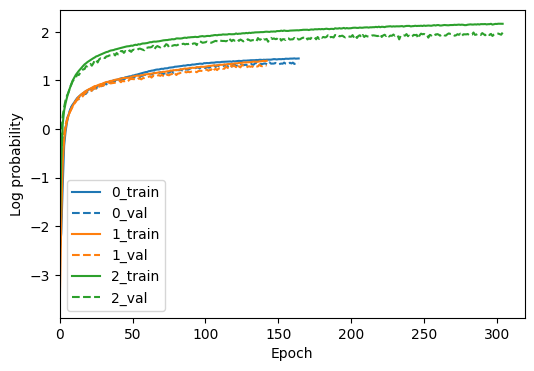

In [17]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(-1.0*np.array(m['training_loss']),
            ls='-', label=f"{i}_train", c=c[i])
    ax.plot(-1.0*np.array(m['validation_loss']),
            ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 256 posterior samples: 314it [00:00, 139587.86it/s]           
Drawing 268 posterior samples: 297it [00:01, 209.44it/s]                         
Drawing 476 posterior samples: 567it [00:00, 572.23it/s]                         


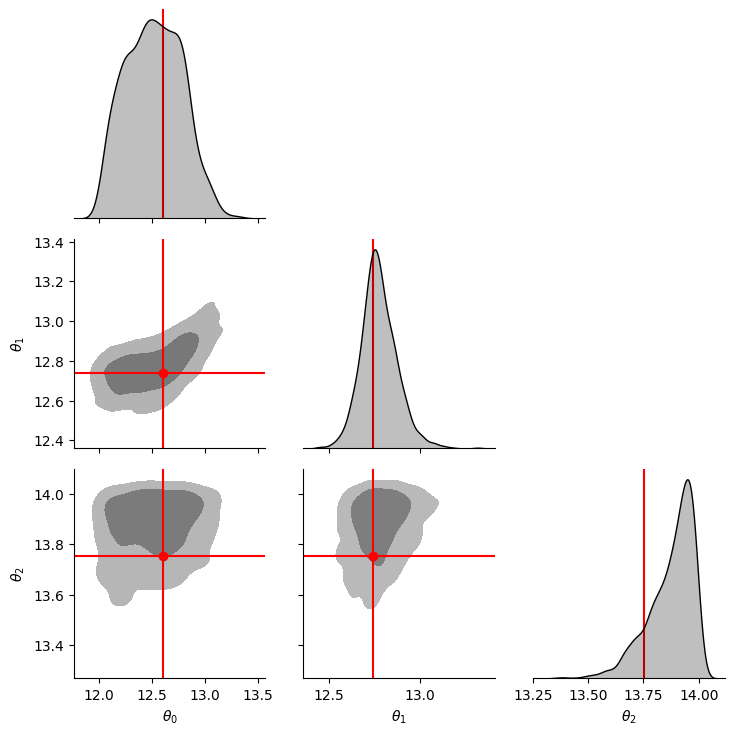

In [18]:
ind = 0
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs=x[ind], theta_fid=theta[ind],
    plot_kws=dict(fill=True)
)

100%|██████████| 86/86 [03:30<00:00,  2.45s/it]
INFO:root:Mean logprob: 1.9826e+00Median logprob: 1.9927e+00
100%|██████████| 100/100 [00:00<00:00, 178.15it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


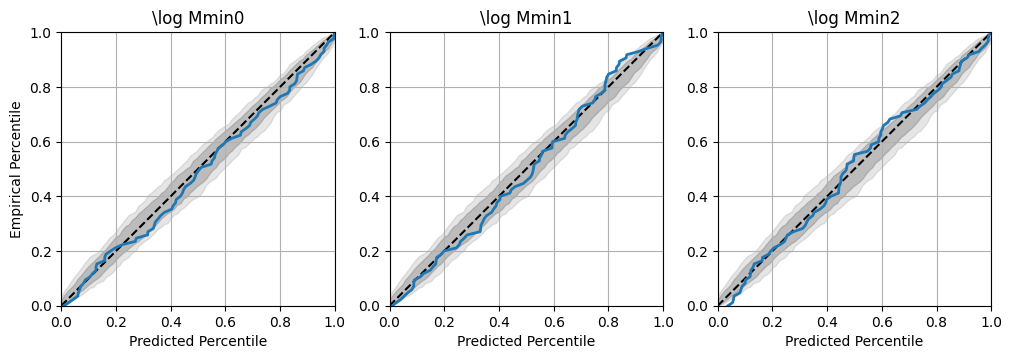

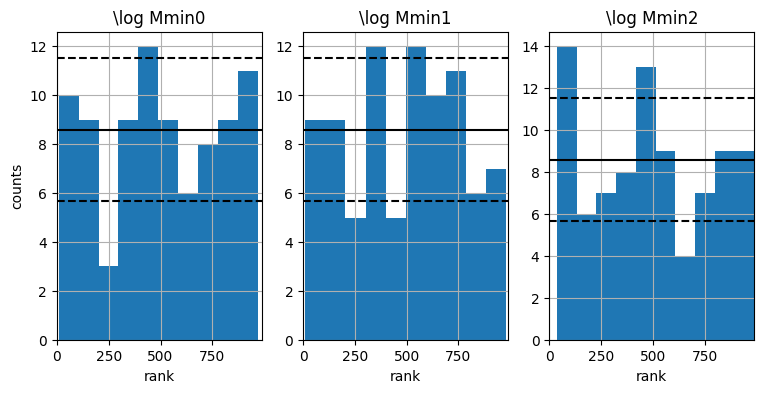

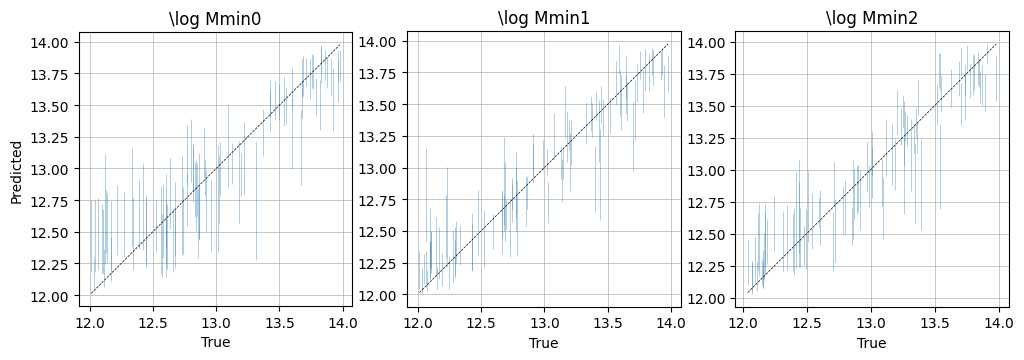

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


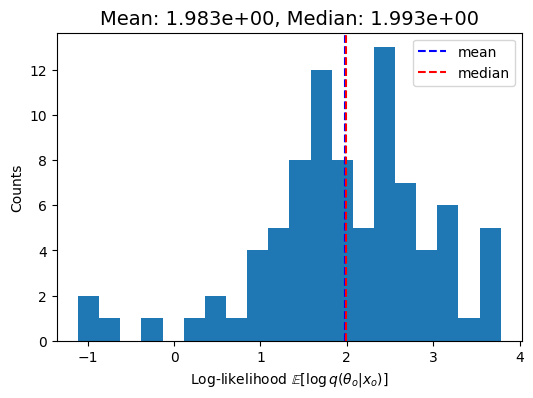

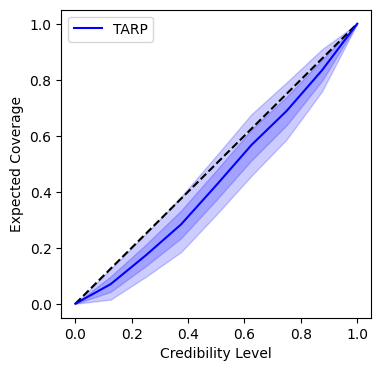

In [20]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=[f'\log Mmin{i}' for i in range(3)],
    plot_list=["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble,  # NeuralPosteriorEnsemble instance from sbi package
    x=x[::171], theta=theta[::171]
)

In [21]:
# Test data
if cap == 'simbig':
    # SIMBIG
    nbody = 'real_data'
    sim = 'cmass_simbig'
    L, N = 2000, 256
    tracer = 'simbig_lightcone'
    lhid = 0
elif cap == 'mtng':
    # MTNG
    nbody = 'mtng'
    sim = 'nbody'
    L, N = 3000, 384
    tracer = 'mtng_lightcone'
    lhid = 0
elif cap == 'sgc':
    # SGC
    nbody = 'real_data'
    sim = 'cmass_sgc'
    L, N = 2000, 256
    tracer = 'sgc_lightcone'
    lhid = 0
elif cap == 'ngc':
    # NGC
    nbody = 'real_data'
    sim = 'cmass_ngc'
    L, N = 3000, 384
    tracer = 'ngc_lightcone'
    lhid = 0
else:
    raise ValueError(f"Unknown cap: {cap}")

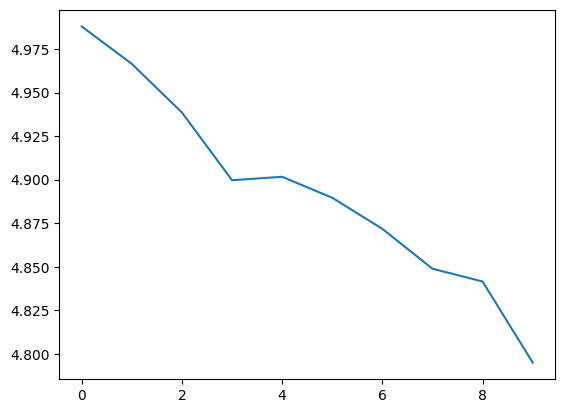

In [22]:
suitedir = join(wdir, nbody, sim, f'L{L}-N{N}')
file = 'hod00000_aug00000.h5'

filepath = join(suitedir, str(lhid), tracer, file)

with h5py.File(filepath, 'r') as f:
    redshifts = f['z'][:]
nzbins = np.linspace(0.4, 0.7, 101)
nzcens = 0.5 * (nzbins[1:] + nzbins[:-1])
nz = np.histogram(redshifts, bins=nzbins)[0]

xobs = np.array([nz])

xobs = np.log10(np.sum(xobs.reshape(len(xobs), -1, 10), axis=-1))

if tracer == 'simbig_lightcone':
    # ignore the 0 redshift bins
    xobs = xobs[:, 1:7]

plt.plot(xobs[0])

Drawing 282 posterior samples: 367it [00:00, 146600.91it/s]           
Drawing 232 posterior samples: 283it [00:02, 101.77it/s]                        
Drawing 486 posterior samples: 585it [00:01, 580.04it/s]                         


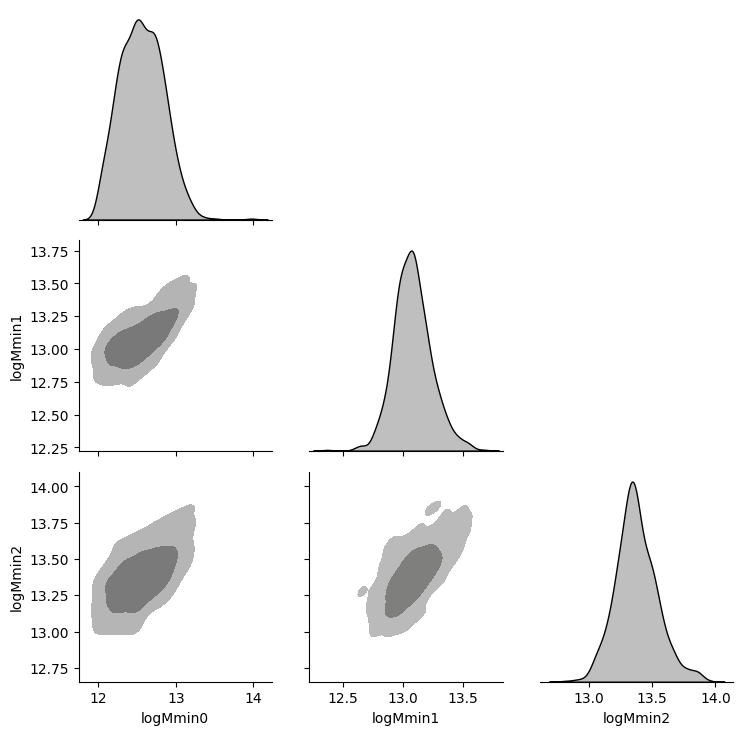

In [27]:
ind = 0
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=[f'logMmin{i}' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs=xobs,
    plot_kws=dict(fill=True)
)

In [24]:
samples = posterior_ensemble.sample(
    (100_000,), torch.Tensor(xobs).to(device))
samples = np.array(samples)

print('\n', tracer)
print('\nMean:\n', repr(list(np.mean(samples, axis=0))))
print('\nStdev:\n', repr(list(np.std(samples, axis=0))))
print('\nCorrelation matrix:\n', repr(np.corrcoef(samples.T)))

Drawing 26440 posterior samples: 29093it [00:00, 220572.88it/s]           
Drawing 25031 posterior samples: 26180it [00:03, 8231.08it/s]                           
Drawing 48529 posterior samples: 49992it [00:13, 3723.78it/s]                           


 mtng_lightcone

Mean:
 [12.554176, 13.085015, 13.378918]

Stdev:
 [0.278381, 0.16197905, 0.16016585]

Correlation matrix:
 array([[1.        , 0.64888494, 0.54721209],
       [0.64888494, 1.        , 0.66465648],
       [0.54721209, 0.66465648, 1.        ]])


In [25]:
# save to disk
hodfile = join(wdir, 'hod_priors', f'{cap}.csv')

# Save the samples to a CSV file
np.savetxt(hodfile, samples, delimiter=',', fmt='%.4f',
           header=','.join(names), comments='')
